# 전이 학습 - 특성 추출 기법

In [ ]:
# 라이브러리 호출

import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train

In [ ]:
# 이미지 데이터 전처리 방법 정의

data_path = '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/train'

transform = transforms.Compose( # 여러 개의 변환을 순차적으로 적용
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224), # 랜덤하게 Crop한 후에 주어진 크기만큼 Resize
        transforms.RandomHorizontalFlip(), # Default 0.5의 확률로 좌우반전
        transforms.ToTensor()
    ]
)

# datasets.ImageFolder : 데이터로더가 데이터를 불러올 대상과 방법을 정의함
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
# DataLoader : 이미지를 불러오는 부분 (num_workers : 하위 프로세스를 몇 개 사용할 것인지)
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)

print(len(train_dataset))

385


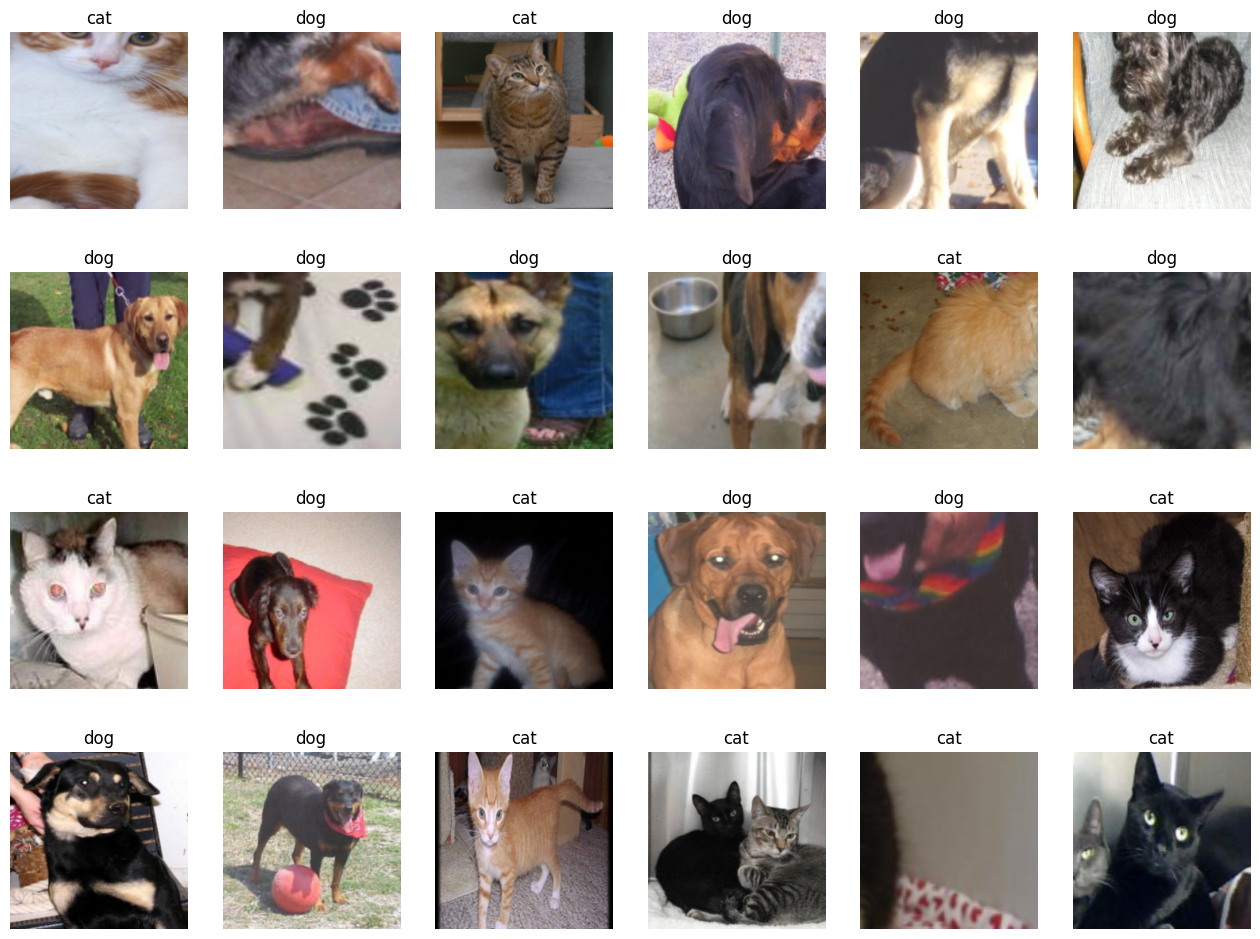

In [ ]:
# 학습에 사용될 이미지 출력

samples, labels = next(iter(train_loader)) # iter()로 반복자를 구하고, 그 반복자를 next()에 전달하며 차례대로 꺼냄 -> train_loader안에서 샘플 이미지와 레이블을 순차적으로 꺼내 저장
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) # class[0] = 'cat' 또는 class[1] = 'dog'
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # 텐서를 넘파이로 변환, (C,H,W)->(H,W,C)로 차원 변환
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

c.f.) `iter()`, `next()`

In [ ]:
lst = [1, 2, 3]
it = iter(lst)

print(next(it))
print(next(it))
print(next(it))

1
2
3


In [ ]:
# 사전 훈련된 모델 내려받기

resnet18 = models.resnet18(pretrained=True) # pretrained=True : 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


💡 **ResNet18**

ResNet18은 50개의 계층으로 구성된 CNN

ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련됨

전이 학습에 사용하도록 사전 훈련된 모델을 제공하고 있음

하지만 입력 제약이 매우 크고, 충분한 메모리(RAM)가 없으면 학습 속도가 느릴 수 있음

In [ ]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정 (파라미터 변화를 계산할 필요가 없음)

set_parameter_requires_grad(resnet18)

In [ ]:
# ResNet18에 fully-connected layer 추가

resnet18.fc = nn.Linear(512, 2) # 2 : 클래스 2개 (cat, dog)

In [ ]:
# (참고용) 모델의 파라미터 값들 확인

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0031,  0.0303,  0.0014,  ..., -0.0188,  0.0435, -0.0380],
        [ 0.0116, -0.0417, -0.0419,  ..., -0.0382, -0.0262,  0.0052]])
fc.bias tensor([-0.0349,  0.0131])


In [ ]:
# 모델 객체 생성 및 손실 함수 정의

model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 학습을 위한 함수 생성

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad() # 그래디언트 초기화
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # backpropagation
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/',
                                                    '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장해두기
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
# 파라미터 학습 결과를 옵티마이저에 전달 (fully-connected layer의 학습)

params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [ ]:
# 모델 학습

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.3984 Acc: 0.8260

Epoch 1/12
----------
Loss: 0.3243 Acc: 0.8935

Epoch 2/12
----------
Loss: 0.2950 Acc: 0.8987

Epoch 3/12
----------
Loss: 0.2519 Acc: 0.9065

Epoch 4/12
----------
Loss: 0.2603 Acc: 0.8987

Epoch 5/12
----------
Loss: 0.2135 Acc: 0.9325

Epoch 6/12
----------
Loss: 0.2193 Acc: 0.9377

Epoch 7/12
----------
Loss: 0.1966 Acc: 0.9377

Epoch 8/12
----------
Loss: 0.2546 Acc: 0.8805

Epoch 9/12
----------
Loss: 0.2586 Acc: 0.8909

Epoch 10/12
----------
Loss: 0.2351 Acc: 0.9065

Epoch 11/12
----------
Loss: 0.2686 Acc: 0.8675

Epoch 12/12
----------
Loss: 0.1845 Acc: 0.9325

Training complete in 12m 20s
Best Acc: 0.937662


## Test

In [ ]:
# 테스트 데이터 호출 및 전처리

test_path = '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

print(len(test_dataset))

98


In [ ]:
# 테스트 데이터 평가 함수 생성

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/*.pth') # glob : 현재 디렉토리에서 pth 확장자를 갖는 파일(모델 훈련 시 생성됨)만 가져옴
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders: # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1) # torch.max : 주어진 텐서 배열의 최댓값이 들어있는 인덱스를 반환
            preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [ ]:
# 테스트 데이터를 평가 함수에 적용

val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/00.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/01.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/02.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/03.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/04.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/05.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/06.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/07.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/08.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/09.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/10.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/11.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/12.pth']
Loading model /content/drive/MyDrive/Colab Notebooks/Euron/catanddog/00.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/Colab Notebooks/

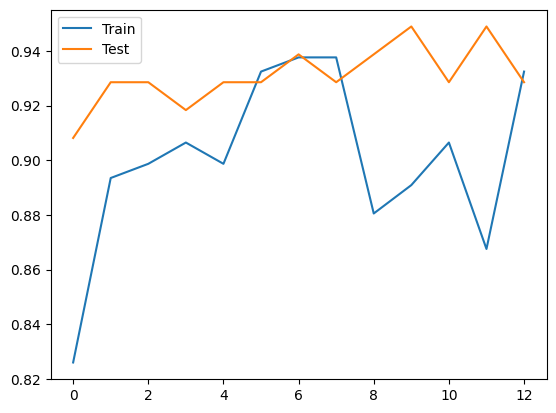

In [ ]:
# Train/test data의 정확도를 그래프로 확인

plt.plot(train_acc_hist, label='Train')
plt.plot(val_acc_hist, label='Test')
plt.legend(loc=0)
plt.show()

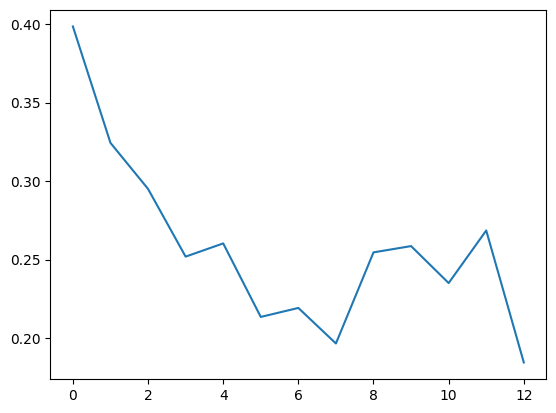

In [ ]:
# Training data의 오차에 대한 그래프 확인

plt.plot(train_loss_hist)
plt.show()

In [ ]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image = tensor.clone().detach().numpy() # 기존 텐서를 복사한 새로운 텐서 생성 but 기울기에 영향 X
    image = image.transpose(1,2,0)
    image = image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image = image.clip(0,1) # 입력 값이 주어진 범위를 벗어날 때 입력값을 특정 범위로 제한시키기 위해 사용
    return image

| .  | 메모리 | .  |
|----|--------|----|
|`tensor.clone()`|새롭게 할당|계산 그래프에 계속 상주|
|`tensor.detach()`|메모리 공유|계산 그래프에 상주 X|
|`tensor.clone().detach()`|새롭게 할당|계산 그래프에 상주 X|


In [ ]:
exam = np.array([-1.8, -1.2, -0.7, -0.4, 0.0, 0.3, 0.6, 1.9])
print(np.clip(exam, -0.5, 0.5))

[-0.5 -0.5 -0.5 -0.4  0.   0.3  0.5  0.5]


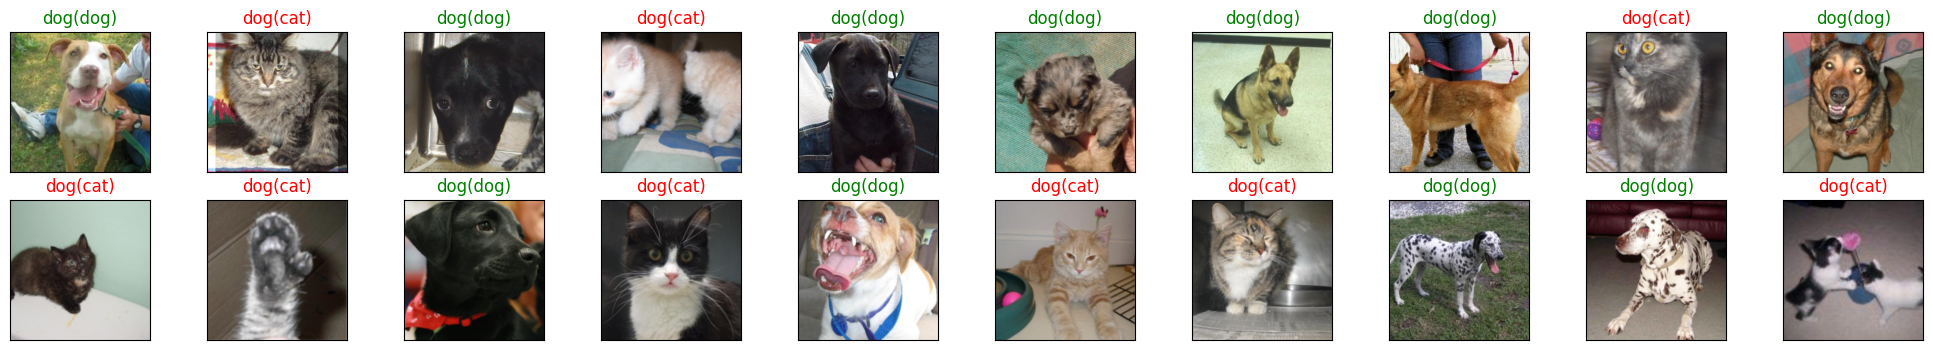

<Figure size 640x480 with 0 Axes>

In [ ]:
# 개와 고양이 예측 결과 출력

classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx])) # 이미지 출력
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

# 설명 가능한 CNN

### 5.4.1 특성 맵 시각화

**PIL** (Python Image Library)
- 이미지 분석 및 처리를 쉽게 할 수 있도록 도와주는 라이브러리
- 다양한 이미지 파일 형식을 지원함
- 강력한 이미지 처리와 그래픽 기능을 제공하는 이미지 프로세싱 라이브러리

In [1]:
# 필요한 라이브러리 호출

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 설명 가능한 네트워크 생성

class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)
        # 로그 소프트맥스 - vanishing gradient problem 해결 위해 로그 취함

In [3]:
# 모델 객체화

model=XAI()
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [4]:
# 특성 맵을 확인하기 위한 클래스 정의

class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # output = output
        # self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self):
        self.hook.remove()

`hook` : 계산 결과에 따라 값이 달라질 수 있는 중간 변수의 기울기 값을 알 수 있음

```
import torch

x = torch.Tensor([0,1,2,3]).requires_grad()
y = torch.Tensor([4,5,6,7]).requires_grad()
w = torch.Tensor([1,2,3,4]).requires_grad()

z = x + y
o = w.matmul(z)
o.backward()

print(x.grad, y.grad, z.grad, w.grad, o,grad)
```
➡️ `tensor([2., 3., 4., 5.]) tensor([2., 3., 4., 5.]) None tensor([4., 6., 8., 10.,]) None`

o와 z는 중간 변수! 파이토치는 이러한 변수에 대해서는 기울기 값을 저장하지 않음

BUT

`z.register_hook(hook_fn)` 사용하면 기울기 값 알 수 있음

torch.Size([3, 100, 100])


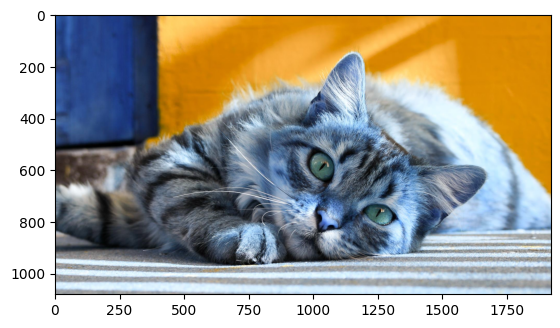

In [7]:
# 이미지 호출

img=cv2.imread("/content/drive/MyDrive/Colab Notebooks/Euron/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR) # 이미지 크기 변경 ~> 보간법으로 픽셀 추정
img = ToTensor()(img) # (채널, 높이, 너비)

print(img.shape)

torch.Size([1, 3, 100, 100])


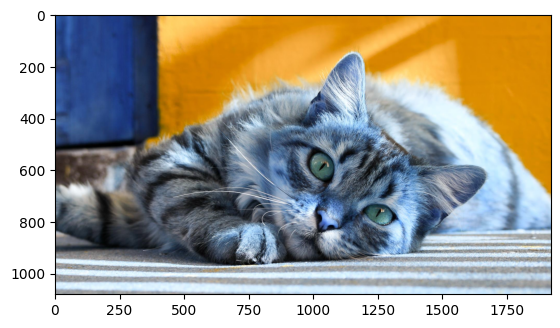

In [9]:
img=cv2.imread("/content/drive/MyDrive/Colab Notebooks/Euron/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR) # 이미지 크기 변경 ~> 보간법으로 픽셀 추정
img = ToTensor()(img).unsqueeze(0) # unsqueeze(0) : 0번째 차원에 1인 차원 생성 -> (배치 크기, 채널, 높이, 너비) => 차원 맞추는 전처리

print(img.shape)

In [10]:
# (0) : Conv2d 특성 맵 확인

result = LayerActivations(model.features, 0)
model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


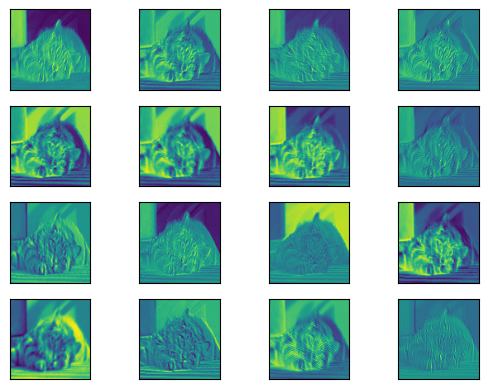

<Figure size 1200x800 with 0 Axes>

In [11]:
# 특성 맵 확인

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [12]:
result = LayerActivations(model.features, 20) # 20번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


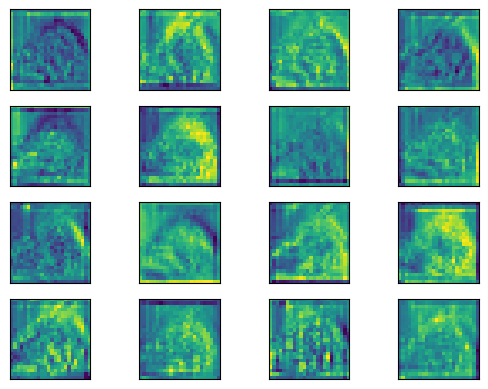

<Figure size 1200x800 with 0 Axes>

In [13]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [14]:
result = LayerActivations(model.features, 40) # 40번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


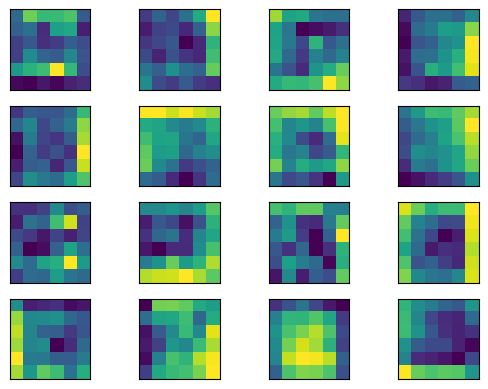

<Figure size 1200x800 with 0 Axes>

In [15]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()